## This file contains one commented process of loading, preparing and splitting one dataset and creating, training and evaluating one model.

### More training with different hyperparameters in other files.

In [1]:
from imports import *

2024-06-23 12:40:22.547561: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 12:40:22.570813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 12:40:22.570829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 12:40:22.570845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 12:40:22.575530: I tensorflow/core/platform/cpu_feature_g

In [2]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
from load_data import DataLoader
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()
data_loader = DataLoader()

## 0. Data loading

This file works with forex EURUSD currency pair with candles measured every 15 minutes.

In [3]:
data, pip_factor= data_loader.load_eurusd_15min()

In [5]:
data.head()

,time,open,high,low,close,volume
49999,2022-05-04 07:30,1.05122,1.05267,1.05108,1.05240,3774
50000,2022-05-04 07:45,1.05241,1.05267,1.05204,1.05240,3192
50001,2022-05-04 08:00,1.05241,1.05282,1.05186,1.05239,2919
50002,2022-05-04 08:15,1.05241,1.05266,1.05170,1.05246,3713
50003,2022-05-04 08:30,1.05246,1.05328,1.05240,1.05285,2757


## 1. Data preparation

1.a Replace prices with their filtered versions

In [7]:
b, a = butter(5, 1/8, btype='low', analog=False)
data['bw_open'] = filtfilt(b, a, data['open'])
data['bw_high'] = filtfilt(b, a, data['high'])
data['bw_low'] = filtfilt(b, a, data['low'])
data['bw_close'] = filtfilt(b, a, data['close'])

Text(0.5, 0, 'Date')

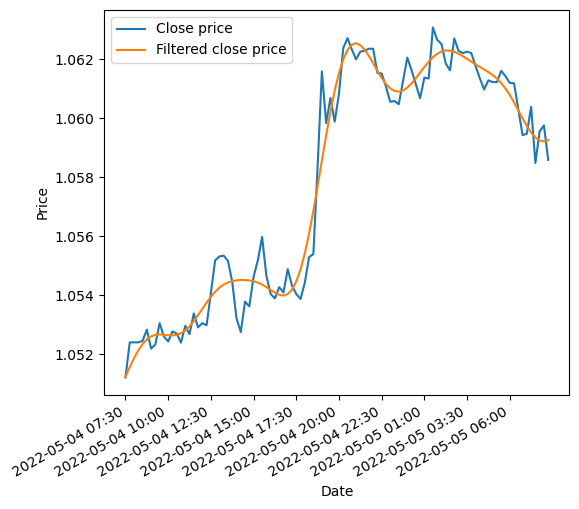

In [34]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)

ax1.plot(data['time'][:100], data['open'][:100], label='Close price')
ax1.plot(data['time'][:100], data['bw_open'][:100], label='Filtered close price')

every_nth = 10
xticks = data['time'][:100:every_nth]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=30, ha='right');
ax1.legend()
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

Model will be trained on input sequences of length 32 (eight hours) and target sequences of length 4 (one hour)

In [36]:
input_seq_len = 32
output_seq_len = 4

# 60:20:20 split for training validation test sets
train_pct = 0.6
val_pct = 0.2